In [14]:
## This is a demo for atlas
## Author : Avadesh Meduri
## Date : 06/04/2022
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from mpc.abstract_cyclic_gen1 import AbstractGaitGen
from robot_properties_atlas.config import AtlasConfig
from py_biconvex_mpc.ik_utils.abstract_gait_generator import AbstractGaitGenerator

import pinocchio as pin
from matplotlib import pyplot as plt
import numpy as np
from motions.weight_abstract import BiconvexMotionParams
from robot_properties_solo.config import Solo12Config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
robot = AtlasConfig.buildRobotWrapper()
rmodel = robot.model
rdata = robot.data
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
## robot config and init
pin_robot = AtlasConfig.buildRobotWrapper()
urdf_path = AtlasConfig.urdf_path

n_eff = 10
eff_names = ["l_foot_lt", "l_foot_rt", "l_foot_lb", "l_foot_rb", "r_foot_lt", "r_foot_rt", "r_foot_lb", "r_foot_rb"]
hip_names = ["l_leg_hpz", "l_leg_hpz", "l_leg_hpz", "l_leg_hpz", "r_leg_hpz", "r_leg_hpz", "r_leg_hpz", "r_leg_hpz"]
q0 = np.array(AtlasConfig.initial_configuration)
q0[0:2] = 0.0

v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])

v_des = np.array([0.0,0.0,0.0])
w_des = 0.0

plan_freq = 0.05 # sec
update_time = 0.0 # sec (time of lag)

In [4]:
gg = AbstractGaitGen(urdf_path, eff_names, hip_names, x0, plan_freq, q0)

In [19]:
#### Stand Still #########################################
still = BiconvexMotionParams("atlas", "Stand")

# Cnt
still.gait_period = 1.0
still.stance_percent = n_eff*[1.0,]
still.gait_dt = 0.05
still.phase_offset = int(n_eff/2)*[0.0,] + int(n_eff/2)*[0.5,] 

# IK
still.state_wt = np.array([0., 0, 10] + [1000] * 3 + [1.0] * (pin_robot.model.nv - 6) \
                         + [0.00] * 3 + [100] * 3 + [0.5] *(pin_robot.model.nv - 6))

still.ctrl_wt = [0, 0, 1000] + [5e2, 5e2, 5e2] + [1.0] *(pin_robot.model.nv - 6)

still.swing_wt = [1e5, 1e5]
still.cent_wt = [0*5e+1, 0*5e+2]
still.step_ht = 0.4
still.nom_ht = 0.95
still.reg_wt = [5e-2, 1e-5]

# Dyn
still.W_X =        np.array([1e+5, 1e+5, 1e+5, 1e+1, 1e+1, 2e+2, 1e+4, 1e+4, 1e4])
still.W_X_ter = 10*np.array([1e+5, 1e+5, 1e-5, 1e+1, 1e+1, 2e+2, 1e+5, 1e+5, 1e+5])
still.W_F = np.array(4*[5e+4, 5e+4, 5e+8])
still.rho = 5e+4
still.ori_correction = [0.0, 0.0, 0.0]
still.gait_horizon = 7.0

# Gains
still.kp = 3.0
still.kd = 0.1

In [10]:
gg.update_gait_params(still, 0)

Initialized Kino-Dyn planner


In [7]:
viz.viewer.jupyter_cell()

In [20]:
sim_t = 0.0
sim_dt = 0.05
index = 0
pln_ctr = 0
plan_freq = 0.8 # sec
update_time = 0.0 # sec (time of lag)
q = q0
v = v0

lag = int(update_time/sim_dt)

for o in range(1):
    xs, us, f = gg.optimize(q, v, sim_t, v_des, w_des)
    xs = xs[lag:]
    us = us[lag:]
    f = f[lag:]

    for ind in range(int(plan_freq/(sim_dt))):
        viz.display(xs[ind][:robot.model.nq])
        time.sleep(0.001)

    q = xs[int(plan_freq/sim_dt)-1][0:pin_robot.model.nq]
    v = xs[int(plan_freq/sim_dt)-1][pin_robot.model.nq:]

    sim_t += plan_freq

Maximum iterations reached 
Final norm: 5.33695


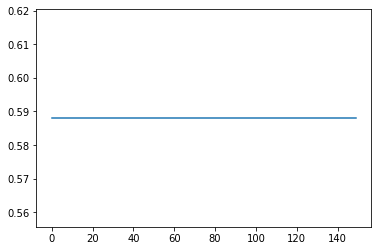

In [21]:
plt.plot(gg.com_int[:,2])

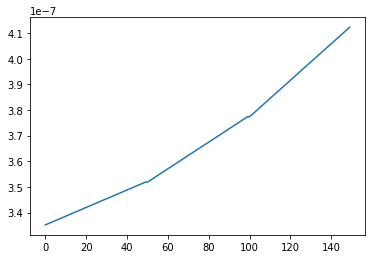

In [30]:
plt.plot(f[:,6])